In [64]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.neighbors import KNeighborsClassifier

from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

Let's actually load data, process data, and do some searching for the best model parameters

Step by step, first showing you the low level ops, then using the easy one liners


In [2]:
# Palmer penguins
df = sns.load_dataset('penguins').dropna()
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
...,...,...,...,...,...,...,...
338,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,Female
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


So we need to convert categorical variables into One-Hot and quantitative variables into z-scored formats.

If category data has no ordering (red, green, blue; species names; etc) then you one-hot in order to make categories orthogonal in their representation so the algorithm doesn't accidentally associate "nearby" categorical inputs with each other.  If your category DOES have ordering (Likert scale) then DO NOT one hot it... just represent it with a 1 to 5 or similar representation that allows similar things (strongly agree and agree) to be associated with each other.

Quantitative variables are transformed such that all variables have similar orders of magnitude, so that one of the variables cannot dominate the others in its importance to prediction.  MinMaxScaler and StandardScaler (z-score) are the most common approaches. 

Let's show you how to do this...



In [21]:
# each column will be transformed such that a value is replaced
# with how many stddev's away from the column mean it is
scaler = StandardScaler()
X_scale = scaler.fit_transform(
    # dropna to get rid of rows with any missing data
    # select ONLY columns that are quantitative 
    df[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].dropna() 
)
pd.DataFrame(X_scale, 
             columns=['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
3,-1.335566,1.085877,-0.569284,-0.941606
4,-0.859415,1.747026,-0.783651,-0.692852
...,...,...,...,...
328,0.587352,-1.762145,0.931283,0.892957
329,0.514098,-1.457000,1.002739,0.799674
330,1.173384,-0.744994,1.502928,1.919069
331,0.221082,-1.202712,0.788372,1.234995


In [25]:
# each column will be transformed such that it turns into 
# a bunch of columns. The # of columns will be the same as 
# the # levels (categories) in the original column
onehot = OneHotEncoder()
X_onehot = onehot.fit_transform( df[['species','island','sex']])
#onehot output is sparse matrix to save memory, need to fill in missing 0s by densifying!
pd.DataFrame(X_onehot.todense(), 
             # onehot encoder can give you back your feature names!
             columns=onehot.get_feature_names_out()
).astype(int) # casting it to int, because nobody likes wasted decimal places

,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_Female,sex_Male
0,1,0,0,0,0,1,0,1
1,1,0,0,0,0,1,1,0
2,1,0,0,0,0,1,1,0
3,1,0,0,0,0,1,1,0
4,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...
328,0,0,1,1,0,0,1,0
329,0,0,1,1,0,0,1,0
330,0,0,1,1,0,0,0,1
331,0,0,1,1,0,0,1,0


OK, great.  We can do that with new datasets, manually doing one set of columns this way, and another set of columns a different way.

BORING!

Let's figure out how to do them all at once... sklearn is all about easy, so there has to be a way to do that...

In [29]:
# anything that's not an object (string) must be a quantitative data type
numerical_columns_selector = selector(dtype_exclude=object)
# anything that IS a string is clearly categorical
categorical_columns_selector = selector(dtype_include=object)

# actually select them
numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

# first argument is just a human readable name,
# second argument is the transformer to apply,
# thrid arg is the columns to apply it to
preprocessor = ColumnTransformer([
    ('onehot', onehot, categorical_columns),
    ('stdscaler', scaler, numerical_columns)])


alldata = preprocessor.fit_transform(df)
pd.DataFrame( alldata, 
            columns=preprocessor.get_feature_names_out())


,onehot__species_Adelie,onehot__species_Chinstrap,onehot__species_Gentoo,onehot__island_Biscoe,onehot__island_Dream,onehot__island_Torgersen,onehot__sex_Female,onehot__sex_Male,stdscaler__bill_length_mm,stdscaler__bill_depth_mm,stdscaler__flipper_length_mm,stdscaler__body_mass_g
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.896042,0.780732,-1.426752,-0.568475
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.822788,0.119584,-1.069474,-0.506286
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-0.676280,0.424729,-0.426373,-1.190361
3,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.335566,1.085877,-0.569284,-0.941606
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.859415,1.747026,-0.783651,-0.692852
...,...,...,...,...,...,...,...,...,...,...,...,...
328,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.587352,-1.762145,0.931283,0.892957
329,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.514098,-1.457000,1.002739,0.799674
330,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.173384,-0.744994,1.502928,1.919069
331,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.221082,-1.202712,0.788372,1.234995


for more usage patterns for ColumnTransformer see 
https://scikit-learn.org/stable/modules/compose.html#column-transformer

### Cross-validation to evaluate performance
NOW its time to get busy.  Recall that k Nearest Neighbors is a very generic classifier. It can fit non-linear decision boundaries, with wavvy wiggly shapes when k is small, and with smooth curves when k is large.  Small k will overfit, large k may underfit.

We also need a cross validator, which will split up the data so that we get a lot of training set and a lot of test set at the same time.  This is what you do to maximize both fit and ability to discern how good the performance is when you don't have internet sized large datasets.

![kfold schematic](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)

In [52]:
# down and dirty with Kfolds

model = KNeighborsClassifier() # default n_neighbors=5
crossval = KFold(n_splits=10) # default n_splits=5
df_transformed = pd.DataFrame(alldata,
                              columns=preprocessor.get_feature_names_out())

mask=df_transformed.columns.str.contains('species')
y=df_transformed.loc[:,mask]
X=df_transformed.loc[:,~mask] #invert mask for non-species columns

folds = []

for train, test in crossval.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    model.fit( X_train, y_train)
    fold_score = model.score( X_test, y_test)
    # every scikit-learn classifier has its own builtin scoring metric
    # for k-NN it is accuracy score, for other estimators it will be something different
    # you could calc this yourself by using
    # from sklearn.metrics import accuracy_score
    # accuracy_score(y_test, model.predict(X_test))
    # to use a different metric (e.g., roc_auc_score) simply import and use as above
    print(fold_score)
    folds.append(fold_score)

print('mean across folds',pd.Series(folds).mean())

0.9411764705882353
1.0
1.0
0.9696969696969697
1.0
0.9393939393939394
1.0
1.0
1.0
1.0
mean across folds 0.9850267379679145


Look at all those lines of code, loops, and slicing dataframes BS.  

SO BORING!!! 

where's my one liner, sklearn????

In [53]:
folds = cross_val_score(estimator=model, X=X, y=y, cv=crossval)
print(folds)
print('mean across folds',pd.Series(folds).mean())

[0.94117647 1.         1.         0.96969697 1.         0.93939394
 1.         1.         1.         1.        ]
mean across folds 0.9850267379679145


Note that the cross validator does not have ```shuffle=True``` as an argument, so it is repeatable as its just taking the data in the order presented.

Depending on your situation that could be a disaster.  What if rows in the dataframe are in the order data arrived? That means data in January is all in the same fold and data from July is all in a seperate fold. What if there are batch effects, such that things in January are all very similar to each other and very different than July?  We would probably want to shuffle in that case... otherwise each training set & test set can be very different in its performance because it is not representative of the data as a whole... variability of holdout performance is a bad thing.   

So if you want to shuffle data for making samples representative, and you need repeatability (for replication) then you would have to set ```random_seed``` as well.

POP QUIZ: How could you check if shuffling changes the varaibility of the test set performance?

### kNN hyperparameters
After you think about that quiz, lets take a look at how a hyperparameter can affect a classifier... the analog of the situation we had with regression, where changing model order made our models underfit, well-fit, or overfit.

Sklearn gives us a handy little helper function that plots where decision boundaries lie... except the stupid thing ONLY works in 2D.  Sheesh.

So to demonstrate how kNN changes as we change the hyperparameter k, lets make a 2d version of our penguins dataset. We will use the first 2 dims of PCA as data (down from 12 in the work above).

We also need to change how the y variable (species) is encoded because of limitations of hte graphing function.

Below, you should change the n_neighbors argument of the model and see how it changes which regions of the 2D dataset will be labelled. The entire dataset is plotted as dots, color encoding species. Any new data that falls in regions of the graph matching that color will be labelled as the same species.


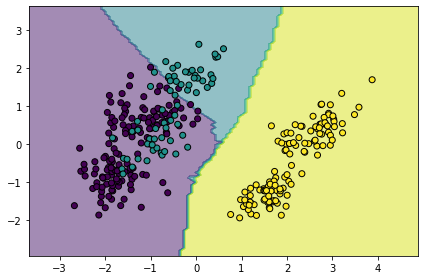

In [98]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

dimreducer = PCA(n_components=2)
X2d = dimreducer.fit_transform(X)

# needs to be labelencoded (1,2,3) because that's all the display function
# can handle... yes its not what you want for classification
ylab = LabelEncoder().fit_transform(df['species'])

# try n_neighbors=1,11,21,45,65
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X2d,ylab)

disp = DecisionBoundaryDisplay.from_estimator(
    model, X2d, response_method="predict", alpha=0.5,
)
disp.ax_.scatter(X2d[:, 0], X2d[:, 1], c=ylab, edgecolor="k");
plt.tight_layout()

Double click in this cell, and describe below how the graph changes as you change n_neighbors

- Your response here